# Zonal mean sea surface temperature

**Call the packages**

In [1]:
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from dask.utils import format_bytes
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
import numpy as np # Pythons standard array library
import xarray as xr # Libary to work with labeled n-dimensional data
import dask # Distributed data libary
import dask.distributed
import multiprocessing
from subprocess import run, PIPE
import sys
import os
import warnings
import pandas as pd
from scipy import stats
warnings.filterwarnings(action='ignore')
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


**Define the nodes to use in this job**

In [2]:
ncpu = multiprocessing.cpu_count()
processes = False
nworker = 1
threads = ncpu // nworker
print(f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}, processes: {processes}")
client = Client(processes=processes,
               threads_per_worker=threads,
               n_workers=nworker,
               memory_limit="64GB"
               )
client

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


<Client: 'inproc://136.172.122.89/467305/1' processes=1 threads=256, memory=59.60 GiB>

## Defining functions

**Zonal mean no crossing the dateline**

In [17]:
def zonal_time_mean_model(file,times,var,lon,environ):
    if environ is 'trop':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4')
        pr=dset1[var].sel(time=slice(times[0],times[1])).sel(lon=slice(lon[0],lon[1])).mean(dim=('time','lon'),skipna=True).compute()
    elif environ is 'ocean':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4')
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        pr=dset1[var].where(lsmask01<0).sel(time=slice(times[0],times[1])).sel(lon=slice(lon[0],lon[1])).mean(dim=('time','lon'),skipna=True).compute()
    elif environ is 'land':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4', parallel=True)
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        pr=dset1[var].where(lsmask01>0).sel(time=slice(times[0],times[1])).sel(lon=slice(lon[0],lon[1])).mean(dim=('time','lon'),skipna=True).compute()
    return pr

In [23]:
def zonal_seasonal_mean_hadisst(file,mon,lon,environ):
    if environ is 'trop':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4')
        dset1 = dset1.rename({'TIME':'time','LATITUDE':'lat','LONGITUDE':'lon'})
        pr = dset1['SST'].groupby('time.month').mean('time').sel(month=slice(mon[0],mon[1]),lon=slice(lon[0],lon[1])).mean(('lon','month')).compute()
    elif environ is 'ocean':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4')
        dset1 = dset1.rename({'TIME':'time','LATITUDE':'lat','LONGITUDE':'lon'})
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        pr = dset1['SST'].groupby('time.month').mean('time').where(lsmask01<0).sel(month=slice(mon[0],mon[1]),lon=slice(lon[0],lon[1])).mean(('lon','month'),skipna=True).compute()
    elif environ is 'land':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4')
        dset1 = dset1.rename({'TIME':'time','LATITUDE':'lat','LONGITUDE':'lon'})
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        pr = dset1['SST'].groupby('time.month').mean('time').where(lsmask01>0).sel(month=slice(mon[0],mon[1]),lon=slice(lon[0],lon[1])).mean(('lon','month'),skipna=True).compute()
    else:
        print('I do not understand')
    return pr

**Zonal mean crossing the dateline**

In [7]:
def zonal_time_mean_model2(file,times,var,lon,environ):
    if environ is 'trop':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4')
        pr=dset1[var].sel(time=slice(times[0],times[1])).where((dset1.lon>lon[0]) | (dset1.lon<lon[1])).mean(dim=('time','lon'),skipna=True).compute()
    elif environ is 'ocean':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4')
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        pr=dset1[var].where(lsmask01<0).sel(time=slice(times[0],times[1])).where((dset1.lon>lon[0]) | (dset1.lon<lon[1])).mean(dim=('time','lon'),skipna=True).compute()
    elif environ is 'land':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4')
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        pr=dset1[var].where(lsmask01>0).sel(time=slice(times[0],times[1])).where((dset1.lon>lon[0]) | (dset1.lon<lon[1])).mean(dim=('time','lon'),skipna=True).compute()
    return pr

In [8]:
def zonal_seasonal_mean_hadisst2(file,mon,lon,environ):
    if environ is 'trop':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4')
        dset1 = dset1.rename({'TIME':'time','LATITUDE':'lat','LONGITUDE':'lon'})
        pr = dset1['SST'].groupby('time.month').mean('time').sel(month=slice(mon[0],mon[1])).where((dset1.lon>lon[0]) | (dset1.lon<lon[1])).mean(('lon','month')).compute()
    elif environ is 'ocean':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4')
        dset1 = dset1.rename({'TIME':'time','LATITUDE':'lat','LONGITUDE':'lon'})
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        pr = dset1['SST'].groupby('time.month').mean('time').where(lsmask01<0).sel(month=slice(mon[0],mon[1])).where((dset1.lon>lon[0]) | (dset1.lon<lon[1])).mean(('lon','month'),skipna=True).compute()
    elif environ is 'land':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4')
        dset1 = dset1.rename({'TIME':'time','LATITUDE':'lat','LONGITUDE':'lon'})
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        pr = dset1['SST'].groupby('time.month').mean('time').where(lsmask01>0).sel(month=slice(mon[0],mon[1])).where((dset1.lon>lon[0]) | (dset1.lon<lon[1])).mean(('lon','month'),skipna=True).compute()
    else:
        print('I do not understand')
    return pr

**List files of interpolated data ICON-S_WarmEq surface temperature**

In [9]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'dpp0052_ts_interpolation_0.25'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/model/interpolation_01/dpp0052/surface_flux')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_dpp0052 = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

**List files of interpolated data ICON-S**

In [10]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'dpp0066'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/model/interpolation_01/dpp0066/surface_flux')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_dpp0066 = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

**List files of HadISST**

In [11]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'HadISST_sst'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/obs/HadISST/')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_hadisst = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

### Results

**Calculate zonal mean sea surface temperature**

In [12]:
times66 = ['2020-02-01','2021-01-31']
var = 'ts'

**Central Pacific (June to September)**

In [13]:
##ICON-S
ts_66_cpac = zonal_time_mean_model2(file_dpp0066,['2020-06-01','2020-09-30'],var,[160,-150],'ocean')

In [14]:
##ICON-S_WarmEq
ts_52_cpac = zonal_time_mean_model2(file_dpp0052,['2020-06-01','2020-09-22'],var,[160,-150],'ocean')

In [15]:
##Climatology of HadISST
ts_hadisst_cpac_sea = zonal_seasonal_mean_hadisst2(file_hadisst,[6,9],[160,-150],'ocean')

**Atlantic (March to May)**

In [18]:
ts_66_atl = zonal_time_mean_model(file_dpp0066,['2020-03-01','2020-05-31'],var,[-50,0],'ocean')

In [19]:
ts_52_atl = zonal_time_mean_model(file_dpp0052,['2020-03-01','2020-05-31'],var,[-50,0],'ocean')

In [24]:
ts_hadisst_atl_sea = zonal_seasonal_mean_hadisst(file_hadisst,[3,5],[-50,0],'ocean')

**Indo_pacific (February-September)**

In [25]:
ts_52 = zonal_time_mean_model(file_dpp0052,['2020-02-01','2020-09-22'],var,[90,180],'ocean')

In [26]:
ts_66 = zonal_time_mean_model(file_dpp0066,['2020-02-01','2020-09-22'],var,[90,180],'ocean')

In [27]:
ts_hadisst_sea = zonal_seasonal_mean_hadisst(file_hadisst,[2,9],[90,180],'ocean')

## Figure S2

In [28]:
from cartopy import crs as ccrs # Cartography library
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import pyplot as plt # Standard Plotting library
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

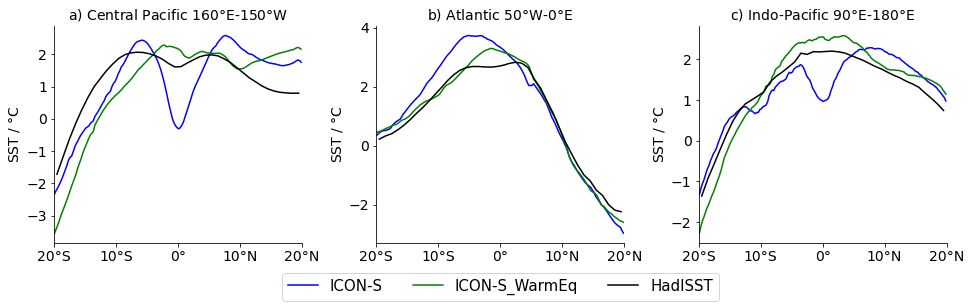

In [29]:
fig1=plt.figure(figsize=(16,4))
ax = fig1.add_subplot(131)
(ts_66_cpac-ts_66_cpac.sel(lat=slice(-30,30)).mean()).sel(lat=slice(-20,20)).plot(\
        color='blue',label='ICON-S',linestyle='-')
(ts_52_cpac-ts_52_cpac.sel(lat=slice(-30,30)).mean()).sel(lat=slice(-20,20)).plot(\
        color='green',label='ICON-S_WarmEq',linestyle='-')
(ts_hadisst_cpac_sea - ts_hadisst_cpac_sea.mean()).sel(lat=slice(-20,20)).plot(\
        color='black',label='HadISST',linestyle='-')
ax.set_title('a) Central Pacific 160$\degree$E-150$\degree$W',fontsize=14)
ax.tick_params(labelsize=16); lat_formatter = LatitudeFormatter(); ax.xaxis.set_major_formatter(lat_formatter)
ax.set_xlabel(None);ax.set_xlim([-20,20])
ax.set_ylabel('SST / $\degree$C', color='k',fontsize=14)  # we already handled the x-label with ax1
ax.tick_params(labelsize=14)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax = fig1.add_subplot(132)
(ts_66_atl-ts_66_atl.sel(lat=slice(-30,30)).mean()).sel(lat=slice(-20,20)).plot(\
        color='blue',label='ICON-S',linestyle='-')
(ts_52_atl-ts_52_atl.sel(lat=slice(-30,30)).mean()).sel(lat=slice(-20,20)).plot(\
        color='green',label='ICON-S_WarmEq',linestyle='-')
(ts_hadisst_atl_sea - ts_hadisst_atl_sea.mean()).sel(lat=slice(-20,20)).plot(\
        color='black',label='HadISST',linestyle='-')
ax.set_title('b) Atlantic 50$\degree$W-0$\degree$E',fontsize=14)
ax.tick_params(labelsize=16); lat_formatter = LatitudeFormatter(); ax.xaxis.set_major_formatter(lat_formatter)
ax.set_xlabel(None);ax.set_xlim([-20,20])
ax.set_ylabel('SST / $\degree$C', color='k',fontsize=14)  # we already handled the x-label with ax1
ax.tick_params(labelsize=14)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax = fig1.add_subplot(133)
lb1=(ts_66-ts_66.sel(lat=slice(-30,30)).mean()).sel(lat=slice(-20,20)).plot(\
        color='blue',label='ICON-S',linestyle='-')
lb2=(ts_52-ts_52.sel(lat=slice(-30,30)).mean()).sel(lat=slice(-20,20)).plot(\
        color='green',label='ICON-S_WarmEq',linestyle='-')
lb3=(ts_hadisst_sea - ts_hadisst_sea.mean()).sel(lat=slice(-20,20)).plot(\
        color='black',label='HadISST',linestyle='-')
ax.set_title('c) Indo-Pacific 90$\degree$E-180$\degree$E',fontsize=14)
ax.tick_params(labelsize=16); lat_formatter = LatitudeFormatter(); ax.xaxis.set_major_formatter(lat_formatter)
ax.set_xlabel(None);ax.set_xlim([-20,20])
ax.set_ylabel('SST / $\degree$C', color='k',fontsize=14)  # we already handled the x-label with ax1
ax.tick_params(labelsize=14)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

lns = lb1+lb2+lb3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='lower center', bbox_to_anchor=(-0.8, -0.3),
          ncol=3, fancybox=True, shadow=False, fontsize=15)
plt.subplots_adjust(wspace=0.3)
plt.savefig('/scratch/m/m300876/results/precip_paper/zonal_mean_sst_tropical_region_ocean_Pacific_Altantic_IndoPacific_ICON_HadISST.png',dpi=400,format='png',bbox_inches='tight',orientation={'landscape'})
